## Constrained programming with PPC

In [1]:
from config import setup
setup()

In [100]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import pairwise_distances
Data, y = make_blobs(n_samples=100, centers=3, n_features=2,random_state=0)
ml=[(1,5),(5,6)]
cl=[(1,3),(4,7)]
print(Data[:5])

[[ 2.63185834  0.6893649 ]
 [ 0.08080352  4.69068983]
 [ 3.00251949  0.74265357]
 [-0.63762777  4.09104705]
 [-0.07228289  2.88376939]]


In [101]:
from docplex.cp.model import CpoModel


def create_csp_clustering(P): #P is the set of data and constraints
    mdl = CpoModel(name='Clustering constraints')
    print("Calculating distances...")
    Dist = pairwise_distances(P)
    
    k_min = 3
    k_max = 3
    N = len(P)
    
    #Creating vars
    
    k=mdl.integer_var(k_min,k_max,"k")
    # D=mdl.float_var(min(Dist),+inf)
    # S=mdl.float_var(-inf, max(Dist))
    # V=mdl.float_var(0,+inf)
    Labels = mdl.integer_var_list(N, 1, k_max, "x") # xi = n if xi is in cluster n
    
    #Partition constraints
    
    ##k must grow with the number of clusters
    for i in range(N):
        mdl.add(Labels[i] <= k)
    
    ##break cluster symmetry by forcing order(Use precede if found)
    mdl.add(Labels[0] == 1) # First cluster is labbelled 1
    for i in range(1,N):
        mdl.add(Labels[i] <= mdl.max(Labels[:i]) + 1)

        
    #User constraints
    ##Must-link
    #for i in range(N):
    #    for j in range(N):
    #        if Mustlink[i,j]:
    #            mdl.add(Labels[i]==Labels[j])
    for i,j in ml:
         mdl.add(Labels[i]==Labels[j])       
    # mdl.add(D > Dist(i,j))
    ##Cannot-link
    #for i in range(N):
    #    for j in range(N):
    #        if Cannotlink[i,j]:
    #            mdl.add(Labels[i]!=Labels[j])
    for i,j in cl:
         mdl.add(Labels[i]!=Labels[j])       
    # mdl.add(S < Dist(i,j))
    
    #Optimization constraint
    # mdl.add(D==diameter(Labels,Dists))
    # mdl.add(S==split(Labels,Dists))
    # mdl.add(V==wcsd(Labels,Dists))
    
    
    #D diameter
    mdl.add(mdl.minimize( \
        mdl.max([(Labels[i] == Labels[j]) * Dist[i,j] for i in range(N) for j in range(N)])))
        
    # mdl.add(mdl.maximize(score))
    print("Done.")    
    return mdl,Labels

In [102]:
mdl,lbls = create_csp_clustering(Data)

Calculating distances...
Done.


In [103]:
#print(mdl.propagate())
print(mdl.solve())
sol=mdl.solve()
Attrib=[sol.get_value(lbl) for lbl in lbls]

-------------------------------------------------------------------------------
Model constraints: 204, variables: integer: 101, interval: 0, sequence: 0
Solve status: Optimal
Solve time: 0.15 sec
-------------------------------------------------------------------------------
Objective values: (4.6919,)
k: 3
x0: 1
x1: 2
x10: 3
x11: 3
x12: 1
x13: 3
x14: 2
x15: 1
x16: 2
x17: 2
x18: 2
x19: 2
x2: 1
x20: 2
x21: 2
x22: 2
x23: 2
x24: 1
x25: 1
x26: 1
x27: 1
x28: 2
x29: 2
x3: 3
x30: 3
x31: 1
x32: 1
x33: 3
x34: 2
x35: 2
x36: 3
x37: 1
x38: 1
x39: 2
x4: 3
x40: 2
x41: 1
x42: 1
x43: 3
x44: 3
x45: 2
x46: 1
x47: 1
x48: 2
x49: 2
x5: 2
x50: 2
x51: 1
x52: 2
x53: 1
x54: 2
x55: 2
x56: 1
x57: 1
x58: 2
x59: 1
x6: 2
x60: 1
x61: 2
x62: 2
x63: 2
x64: 2
x65: 1
x66: 3
x67: 2
x68: 1
x69: 3
x7: 2
x70: 2
x71: 1
x72: 2
x73: 1
x74: 1
x75: 1
x76: 2
x77: 2
x78: 2
x79: 1
x8: 1
x80: 3
x81: 3
x82: 1
x83: 2
x84: 1
x85: 3
x86: 3
x87: 2
x88: 1
x89: 2
x9: 2
x90: 1
x91: 1
x92: 2
x93: 2
x94: 2
x95: 2
x96: 2
x97: 1
x98: 2
x99: 2


In [108]:
import collections

def cons_linking(cons):
    dico = collections.defaultdict(set) # pt => list of pts
    # linked = collections.defaultdict(set) # nb => list of pt
    asso = dict() # pt => nb
    for pt1, pt2 in cons:
        dico[pt1].add(pt2)
        dico[pt1].add(pt1)
        dico[pt2].add(pt1)
        dico[pt2].add(pt2)
        asso[pt1] = pt1
        asso[pt2] = pt2

    pts = set(dico.keys())
    for pt in pts:
        for pt2 in pts :
            # if the intersection is not empty
            if asso[pt] != asso[pt2] \
            and not not dico[asso[pt]].intersection(dico[asso[pt2]]):
                dico[asso[pt]].update(dico[asso[pt2]])
                asso[pt2] = pt
                del dico[pt2]

    return list(dico.values())

new_cons = cons_linking(ml)
# Plotting the constraints
# Plotting the equality constraints
for cons in new_cons:
    new_X_x = []
    new_X_y = []
    for pt in cons :
        new_X_x.append(Data[pt, 0])
        new_X_y.append(Data[pt, 1])

    plt.plot(new_X_x,new_X_y,
             'r^', linewidth=50)

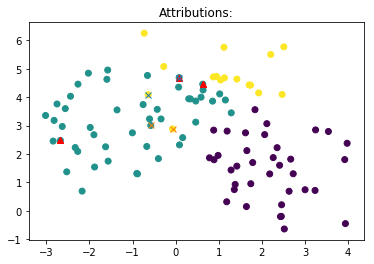

In [109]:
#plotting Cannnotlink
for pt1, pt2 in cl:
    plt.plot([Data[pt1,0],Data[pt2,0]],
             [Data[pt1,1],Data[pt2,1]],
             'x', linewidth=50)

#plotting Mustlink (done above)
#for pt1, pt2 in ml:
#    plt.plot([Data[pt1,0],Data[pt2,0]],
#             [Data[pt1,1],Data[pt2,1]],
#             '^', linewidth=50)

plt.scatter(Data[:,0],Data[:,1],c=Attrib)
plt.title("Attributions:")
plt.show()

In [106]:
print(new_cons)

[{1, 5, 6}]
